In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import torch.optim as optim

In [2]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 250
print('using device:', device)

using device: cuda


In [3]:
#For AlexNet
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
NUM_TRAIN = 49000

# CIFAR100: 60000 32x32 color images in 100 classes, with 500 training and 100 test images per class

cifar100_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

loader_train = DataLoader(cifar100_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar100_val = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

loader_val = DataLoader(cifar100_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar100_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

loader_test = DataLoader(cifar100_test, batch_size=64)

100%|██████████| 169001437/169001437 [00:13<00:00, 12951442.71it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

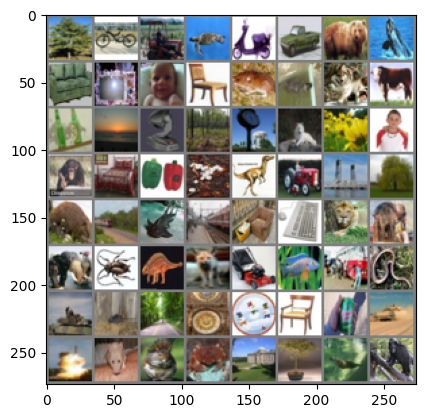

In [6]:
# get some random training images
dataiter = iter(loader_train)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [7]:
#Checking the shape of the images
print(images.shape)

torch.Size([64, 3, 32, 32])


In [8]:
loss_history = []
time_history = []

In [9]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) 
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [10]:
def train_model(model, optimizer, epochs=1):

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        import time
        tic = time.time()
        for t, (x, y) in enumerate(loader_train):
            model.train()  
            x = x.to(device=device, dtype=dtype)  
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            loss_history.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % ((e+1), t, loss.item()))
                check_accuracy(loader_val, model)
                print()
        toc = time.time()
        print('Epoch %d, Time %fmin' % ((e+1), (toc-tic)/60))
        time_history.append((toc-tic)/60)
        print()

In [11]:
learning_rate = 1e-2

model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),  #[16, 16, 64]
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),   #[8, 8, 64]
    nn.Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #[8, 8, 192]
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #[4, 4, 192]
    nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #[4, 4, 384]
    nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #[4, 4, 256]
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #[4, 4, 256]
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #[2, 2, 256]

    nn.Flatten(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1024, out_features=4096, bias=True), #[2*2*256, 4096]
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096, bias=True), #[4096, 4096]
    nn.ReLU(),
    nn.Linear(in_features=4096, out_features=100, bias=True), #[4096, 100]
)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
train_model(model, optimizer, epochs = 20) #Training and checking accuracy on val set

Epoch 1, Iteration 0, loss = 4.6052
Checking accuracy on validation set
Got 17 / 1000 correct (1.70)

Epoch 1, Iteration 250, loss = 4.6078
Checking accuracy on validation set
Got 12 / 1000 correct (1.20)

Epoch 1, Iteration 500, loss = 4.5986
Checking accuracy on validation set
Got 12 / 1000 correct (1.20)

Epoch 1, Iteration 750, loss = 4.5991
Checking accuracy on validation set
Got 12 / 1000 correct (1.20)

Epoch 1, Time 0.406789min

Epoch 2, Iteration 0, loss = 4.6051
Checking accuracy on validation set
Got 9 / 1000 correct (0.90)

Epoch 2, Iteration 250, loss = 4.5186
Checking accuracy on validation set
Got 22 / 1000 correct (2.20)

Epoch 2, Iteration 500, loss = 4.3543
Checking accuracy on validation set
Got 28 / 1000 correct (2.80)

Epoch 2, Iteration 750, loss = 4.1066
Checking accuracy on validation set
Got 34 / 1000 correct (3.40)

Epoch 2, Time 0.284987min

Epoch 3, Iteration 0, loss = 4.3588
Checking accuracy on validation set
Got 32 / 1000 correct (3.20)

Epoch 3, Iteratio

In [13]:
#Checking accuracy on Test set
import time
test_start_time = time.time()
check_accuracy(loader_test, model) 
test_end_time = time.time()
print('Total time taken to run test images: %fmin' %((test_end_time - test_start_time)/60))

Checking accuracy on test set
Got 4122 / 10000 correct (41.22)
Total time taken to run test images: 0.052236min


In [14]:
classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale', 
'aquarium' ,'fish', 'ray', 'shark', 'trout', 
'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 
'bottles', 'bowls', 'cans', 'cups', 'plates', 
'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', 
'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 
'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 
'bear', 'leopard', 'lion', 'tiger', 'wolf', 
'bridge', 'castle', 'house', 'road', 'skyscraper', 
'cloud', 'forest', 'mountain', 'plain', 'sea', 
'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 
'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 
'crab', 'lobster', 'snail', 'spider', 'worm', 
'baby', 'boy', 'girl', 'man', 'woman', 
'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 
'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 
'maple', 'oak', 'palm', 'pine', 'willow', 
'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', 
'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']

In [15]:
# Translate categorial to array for drawing confusion matrix
from sklearn import metrics
from numpy import argmax
y_true =[]
y_pred =[]
for images, labels in loader_test:
  images = images.to(device)
  labels = labels.to(device).cpu().data.numpy().argmax()
  outputs = model(images)
  _, predicted = torch.max(outputs, 1)
  y_pred.append(predicted.cpu().data.numpy().argmax())
  y_true.append(labels)

# print(y_pred)
# print(y_true)

cm = metrics.confusion_matrix(y_pred, y_true)
     

[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<ipython-input-16-29f2d7eea864>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-16-29f2d7eea864>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


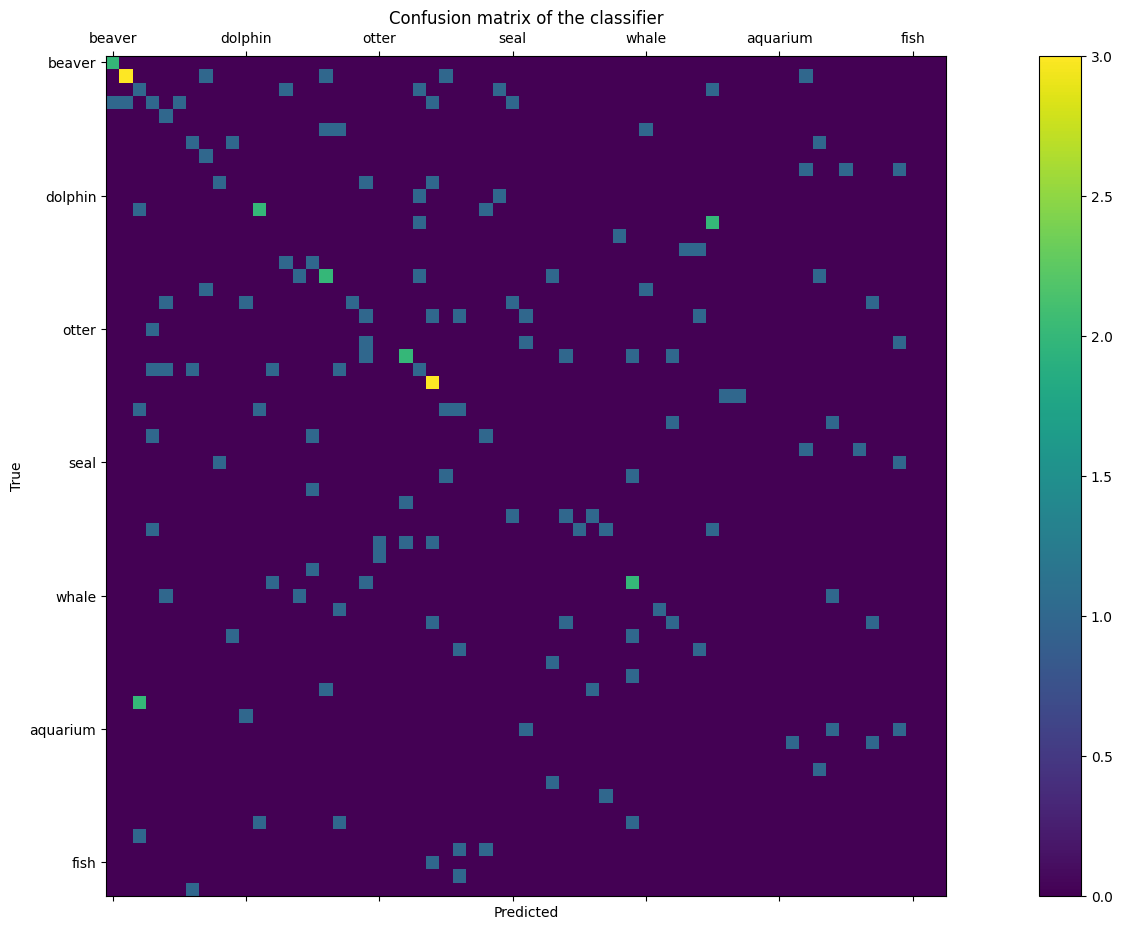

In [16]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
print(cm)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
# Calculating f1 score
from sklearn.metrics import f1_score
print(f"f1 score: {f1_score(y_true, y_pred, average='weighted')}")

f1 score: 0.22371209823439123


In [18]:
labels = []
for i in range(100):
  labels.append(i+1)
# print(labels)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes, digits=5, labels =labels))

                   precision    recall  f1-score   support

           beaver    0.42857   0.75000   0.54545         4
          dolphin    0.20000   0.16667   0.18182         6
            otter    0.16667   0.20000   0.18182         5
             seal    1.00000   0.25000   0.40000         4
            whale    0.00000   0.00000   0.00000         1
         aquarium    0.33333   0.33333   0.33333         3
             fish    1.00000   0.33333   0.50000         3
              ray    0.00000   0.00000   0.00000         2
            shark    0.00000   0.00000   0.00000         2
            trout    0.00000   0.00000   0.00000         2
          orchids    0.50000   0.50000   0.50000         4
          poppies    0.00000   0.00000   0.00000         2
            roses    0.00000   0.00000   0.00000         2
       sunflowers    0.00000   0.00000   0.00000         2
           tulips    0.50000   0.25000   0.33333         4
          bottles    0.33333   0.40000   0.36364       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [20]:
average_time = sum(time_history)/len(time_history)
print('Average running time per epoch: %f min' %average_time)

Average running time per epoch: 0.307491 min


In [21]:
l_hist = []
for i in loss_history:
  i = i.cpu().detach().numpy()
  l_hist.append(i)

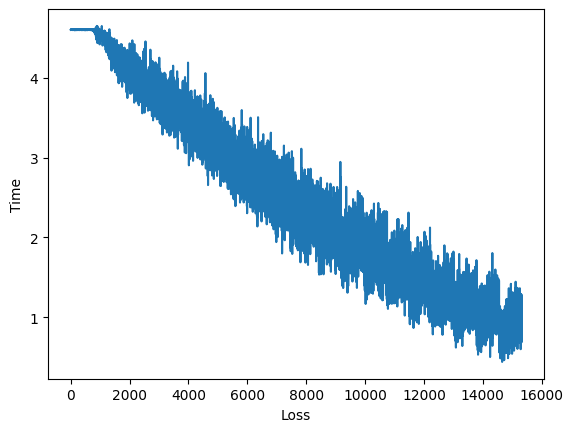

In [22]:
#Plot of loss history
import matplotlib.pyplot as plt
plt.plot(l_hist)
plt.xlabel('Loss')
plt.ylabel('Time')
plt.show()

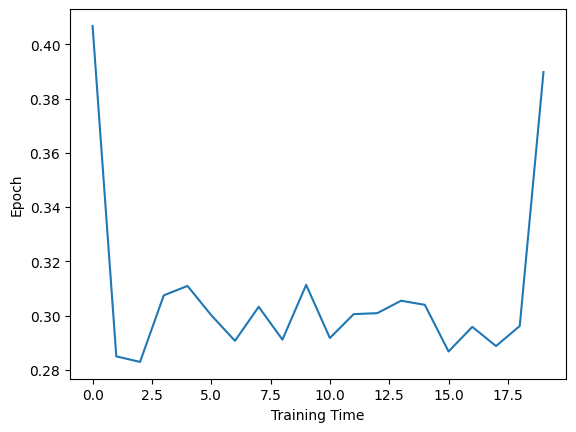

In [23]:
#Plot of training time
import matplotlib.pyplot as plt
plt.plot(time_history)
plt.xlabel('Training Time')
plt.ylabel('Epoch')
plt.show()